# Visual attention - Lab 1 - From the eye-tracker to saliency maps

Created by : Alexandre Bruckert / University of Nantes - alexandre.bruckert@univ-nantes.fr

Date : 2024

In this lab, we will learn how to process eye-tracking data as output by the eye-tracker in order to transform it into a fixation map, or a visual saliency map.

To this end, you will have to fill out the functions specified in this notebook. 

In [1]:
%matplotlib inline

import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import gaussian_filter

PATH_DATA = "./IRCCyN_IVC_Eyetracker_Berkeley_Database"

# Experiment-dependant constants
RESO_X = 1280
RESO_Y = 1024
FACTOR_X = RESO_X/338
FACTOR_Y = RESO_Y/270

First, for each image, we want to gather the files from all observers output by the eye-tracker.
For this dataset, file structure is the following :  
IIRCCyN_IVC_Eyetracker_Berkeley_Database  
> Images  
> Eyetracker_Data  
>>Obs1  
>>.  
>>.     
>>ObsN  
>>> image_img.trn.1.png-obs_ObsN.txt  
>>>.  
>>>.  
>>> image_img.trn.N.png-obs_ObsN.txt  
>>> image_img.tst.1.png-obs_ObsN.txt  
>>>.  
>>>.  
>>> image_img.tst.N.png-obs_ObsN.txt


In [2]:
def get_files_all_observers(dir_path, img_name):
    """
    List all eye-tracking data files related to a particular image.
    
    :param dir_path: str, the path to the directory in which the dataset is stored.
    :param img_name: str, the name of the image for which we want to gather eye-tracking data.
                     This must be of the form img.trn.xxx or img.tst.xxx
    :return list_all_files: list, containing the paths to all the relevant eye-tracking files.
    """
    list_all_files = glob.glob(os.path.join(dir_path, 'Eyetracker_Data/**/*' + img_name + '.*'), recursive=True)
    assert list_all_files, "List of eye-tracking files seem to be empty. Check directory or image name."
    return list_all_files

Now that we have our files, we can start having fun with the data itself.

#### 1) Fill the following function, creating a fixation map based on raw eye-tracking data.

In [3]:
###### TODO ######
def create_fixmap(list_obs_files, img_w, img_h, factor_x, factor_y, t_begin=0, t_end=15):
    """
    Create a fixation map based on raw eye-tracking data.
    
    :param list_obs_files: list, a list of paths to the eye-tracking files of each observer for the considered image
    :param img_w: int, the width of the image, in pixels
    :param imw_h: int, the height of the image, in pixels
    :param factor_x: float, the ratio of the horizontal resolution to the horizontal size of the screen used in the eye-tracking experiment
    :param factor_y: float, the ratio of the vertical resolution to the vertical size of the screen used in the eye-tracking experimen
    :param t_begin: float, the start of the time slice to consider, in s.
    :param t_end: float, the end of the time slice to consider, in s.
    :return fixmap: numpy array, the fixation map.
    """
    # First, let's initialize the fixation map.
    fixmap = np.zeros((img_h, img_w))
    
    for obs in list_obs_files:
        # We will read the files and store them in a pandas dataframe.
        df = pd.read_csv(obs, sep=',', skiprows=19) # The 19 first lines of each file are just calibration data. We won't take them into account in this lab.
        
        # Each observer file represents 15s of viewing.
        # However, we might only be interested in a particular time slice of the data,
        # so we'll filter the dataset using the input time parameters
        
        # keep between t_begin*1000 and t_end*1000
        df = df[(df["TimeStamp"] >= t_begin*1000) & (df["TimeStamp"] <= t_end*1000)]###### TODO ######
        
        # Let's also remove all lines where the eye was not tracked (e.g. because of blinks or tracking errors)
        df = df[df["Tracked"] == 1]###### TODO ######

        
        # Now, we want to aggregate all points belonging to the same fixation into a single point
        # For this, we will create groups of consecutive "Fixation" values, with a little bit of pandas magic !
        fix_groups = df.groupby((df["Fixation"].shift() != df["Fixation"]).cumsum())
        for n_group , group in fix_groups:
            if group["Fixation"].all() != 0:
                # For each detected fixation, we average the location of all gaze points
                x = group["ScreenPositionXmm"].mean() * 0.9
                y = -group["ScreenPositionYmm"].mean() * 0.9
                # Don't worry about the 0.9 coefficient; it's a fix due to errors in the experimental protocol
                # The minus sign before the Y coordinate is due to an inversion in the data, that used to be processed
                # in Matlab.
                # We then find the location of the fixation on the resulting fixation map

                
                # convert coordinates to pixels + center the origin ###### TODO ######
                x_pix = int(x * factor_x + img_w / 2)
                y_pix = int(y * factor_y + img_h / 2)
                #print("x, y:", x, y, "-> x_pix, y_pix:", x_pix, y_pix)
                # And we can finally add the fixation to the map
                
                # remove if outside boundaries
                if 0 <= x_pix < img_w and 0 <= y_pix < img_h : ###### TODO ######
                    fixmap[y_pix, x_pix] += 1
                
    return fixmap

#### 2) Now for a bit of geometry. Create the function compute_ppda, that computes the number of pixels per degree of visual angle based on the experimental conditions.

In [4]:
def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """
    horizontal_ppda = h_res / (2 * math.degrees(math.atan((screen_w / 2) / distance)))###### TODO ######
    vertical_ppda = v_res / (2 * math.degrees(math.atan((screen_h / 2) / distance))) # juste pour voir

    return horizontal_ppda, vertical_ppda

#### 3) Create a function salmap_from_fixmap generating the visual saliency map based on the fixation map, and the number of pixels per degree of visual angle

In [5]:
def salmap_from_fixmap(fixmap, ppda):
    """
    Generate a visual saliency map, based on the fixation map.
    
    :param fixmap: numpy array, the fixation map
    :param ppda: float, the number of pixels per degree of visual angle
    :return salmap: numpy array, the visual saliency map
    """
    salmap = gaussian_filter(fixmap, sigma=ppda) ###### TODO ######
    return salmap

Now, let's visualize the saliency map we generated !

In [6]:
list_img1 = get_files_all_observers(PATH_DATA, 'img.trn.1')
fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
img = mpimg.imread(os.path.join(PATH_DATA, "Images\\img.trn.1.png"))
# Values for the PPDA computation / image sizes / etc come from the experimental conditions.
# You can go read the associated paper for more information !
# J. Wang, D. M. Chandler, P. Le Callet, "Quantifying the relationship between visual salience and visual importance", Spie Human and Electronic imaging (HVEI) XV, San Jose, 2010

hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
salmap = salmap_from_fixmap(fixmap, hppda)

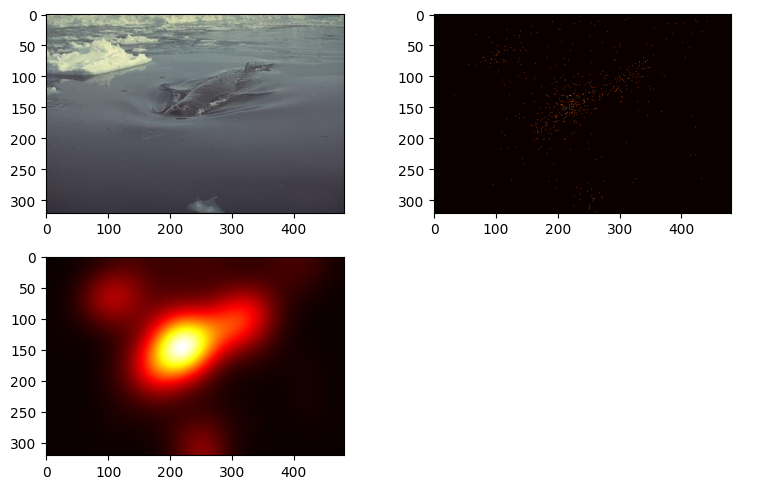

In [7]:
fig, axs = plt.subplots(2,2, figsize=(8,5))
axs[0,0].imshow(img)
axs[0,1].imshow(fixmap, cmap='hot')
axs[1,0].imshow(salmap, cmap='hot')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()

#### 4) Now it's your turn ! Compute and display the saliency maps for a few images in the dataset. Explore it visually, and try to ensure that you haven't make mistakes while computing it. Vary the parameters to compute the map (assuming that the experimental condition changed); what can you say about it ? How does it influence the final representation, and why ?

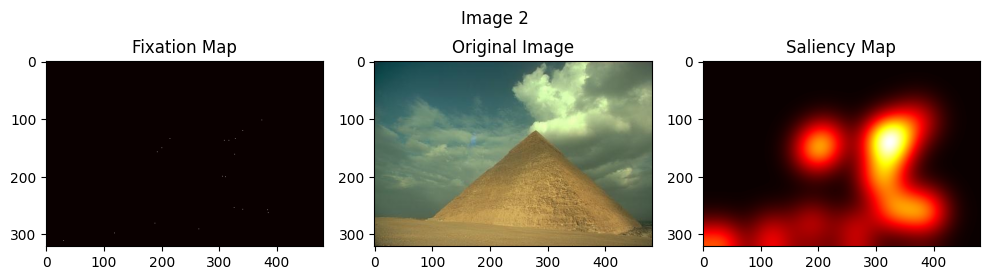

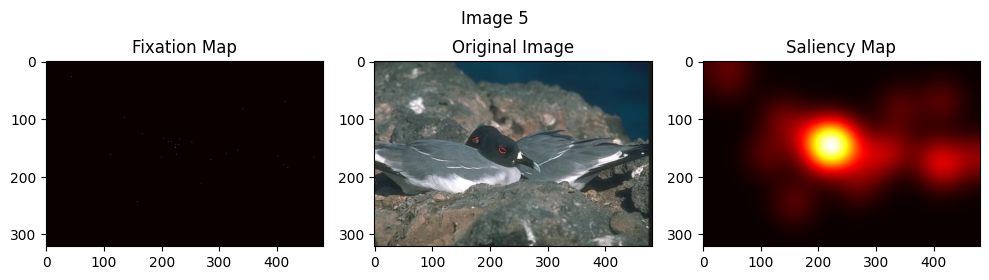

In [8]:
for img_num in [2,5]:
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)

    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, hppda)

    fig, axs = plt.subplots(1,3, figsize=(10,3))
    axs[0].imshow(fixmap, cmap='hot')
    axs[0].set_title('Fixation Map')
    axs[1].imshow(img)
    axs[1].set_title('Original Image')
    axs[2].imshow(salmap, cmap='hot')
    axs[2].set_title('Saliency Map')
    plt.tight_layout()
    plt.suptitle("Image " + str(img_num), fontsize=12)
    plt.show()

Here are a few examples of fixation map and saliency map on two images. The fixation maps have points on it (we can barely see them but they are here)

For the next part I will only focus on saliency maps, that i will show directly on each images to see exactly what part the participants watch.

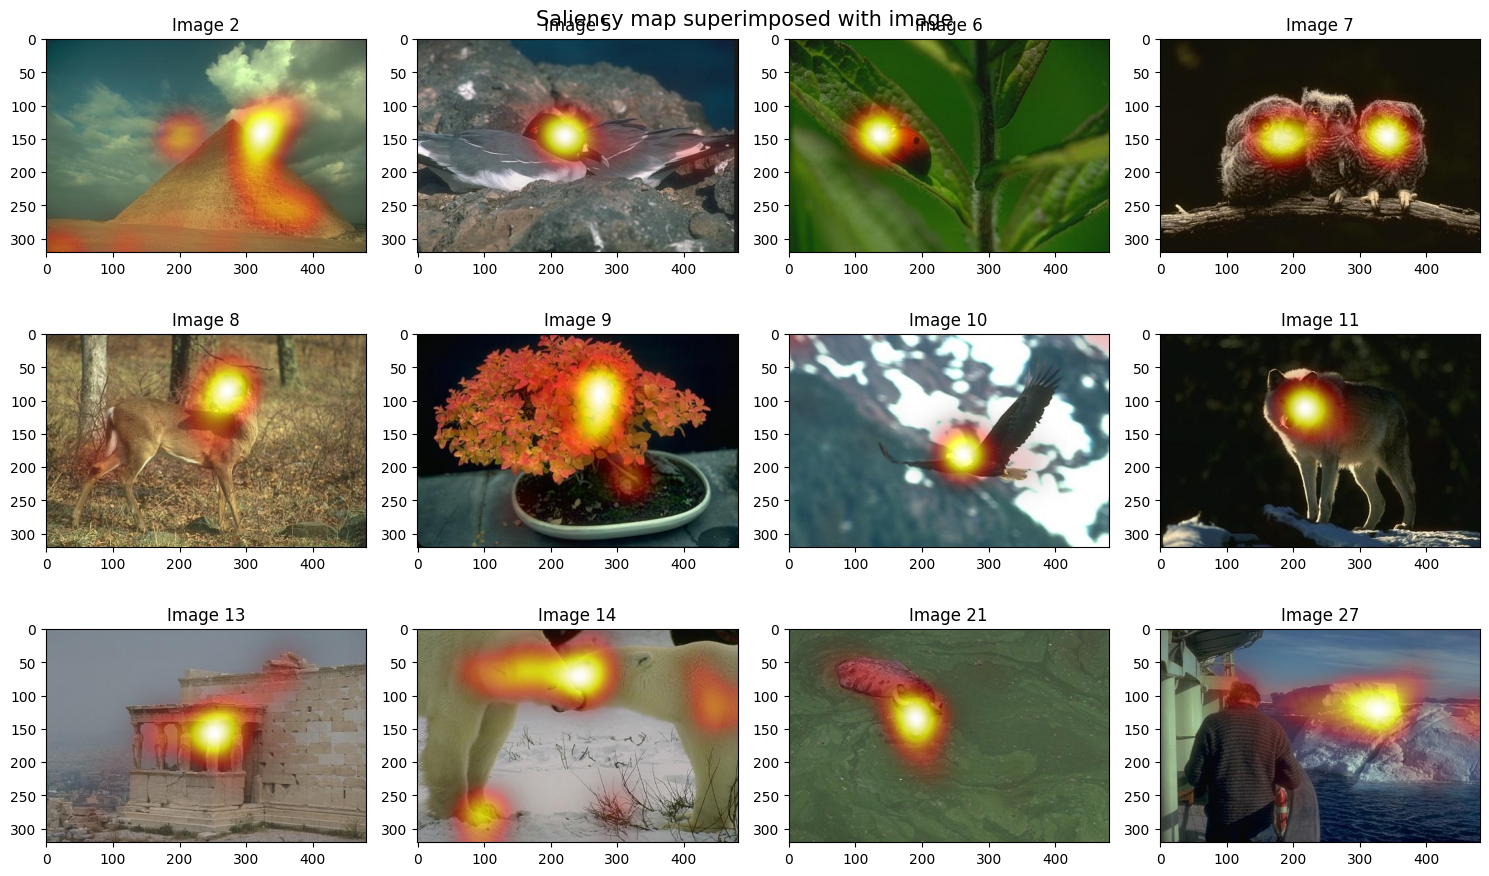

In [9]:
from matplotlib.colors import Normalize

small_img_list = [2,5,6,7,8,9,10,11,13,14,21,27]
ncols = 4
nrows = math.ceil(len(small_img_list) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))

for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, hppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[idx // ncols, idx % ncols].imshow(img)
    axs[idx // ncols, idx % ncols].imshow(salmap_rgba)
    axs[idx // ncols, idx % ncols].set_title(f'Image {img_num}', fontsize=12)
plt.tight_layout()
plt.suptitle("Saliency map superimposed with image", fontsize=15)
plt.show()

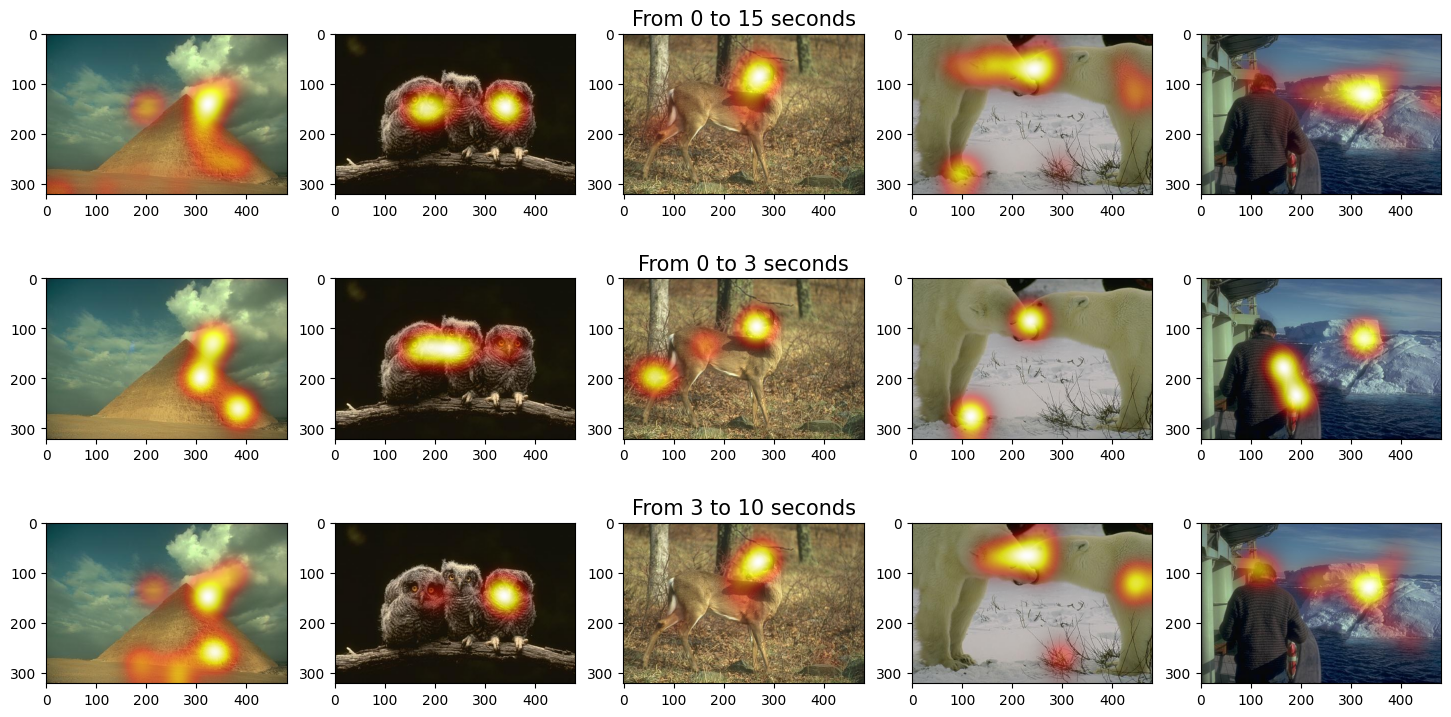

In [10]:
small_img_list = [2,7,8,14,27]
ncols = len(small_img_list)
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3 * nrows))

# Original
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[0, idx % ncols].imshow(img)
    axs[0, idx % ncols].imshow(salmap_rgba)
axs[0, 2].set_title(f'From 0 to 15 seconds', fontsize=15)

# Modified
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y, t_begin=0, t_end=3)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[1, idx % ncols].imshow(img)
    axs[1, idx % ncols].imshow(salmap_rgba)
axs[1, 2].set_title(f'From 0 to 3 seconds', fontsize=15)

# Modified
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y, t_begin=3, t_end=10)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[2, idx % ncols].imshow(img)
    axs[2, idx % ncols].imshow(salmap_rgba)
axs[2, 2].set_title(f'From 3 to 10 seconds', fontsize=15)
plt.show()

On the previous cell I wanted to see the difference of attention between the firsts seconds (0 to 3 seconds) and the following (3 to 10 seconds). We can already see interesting differences

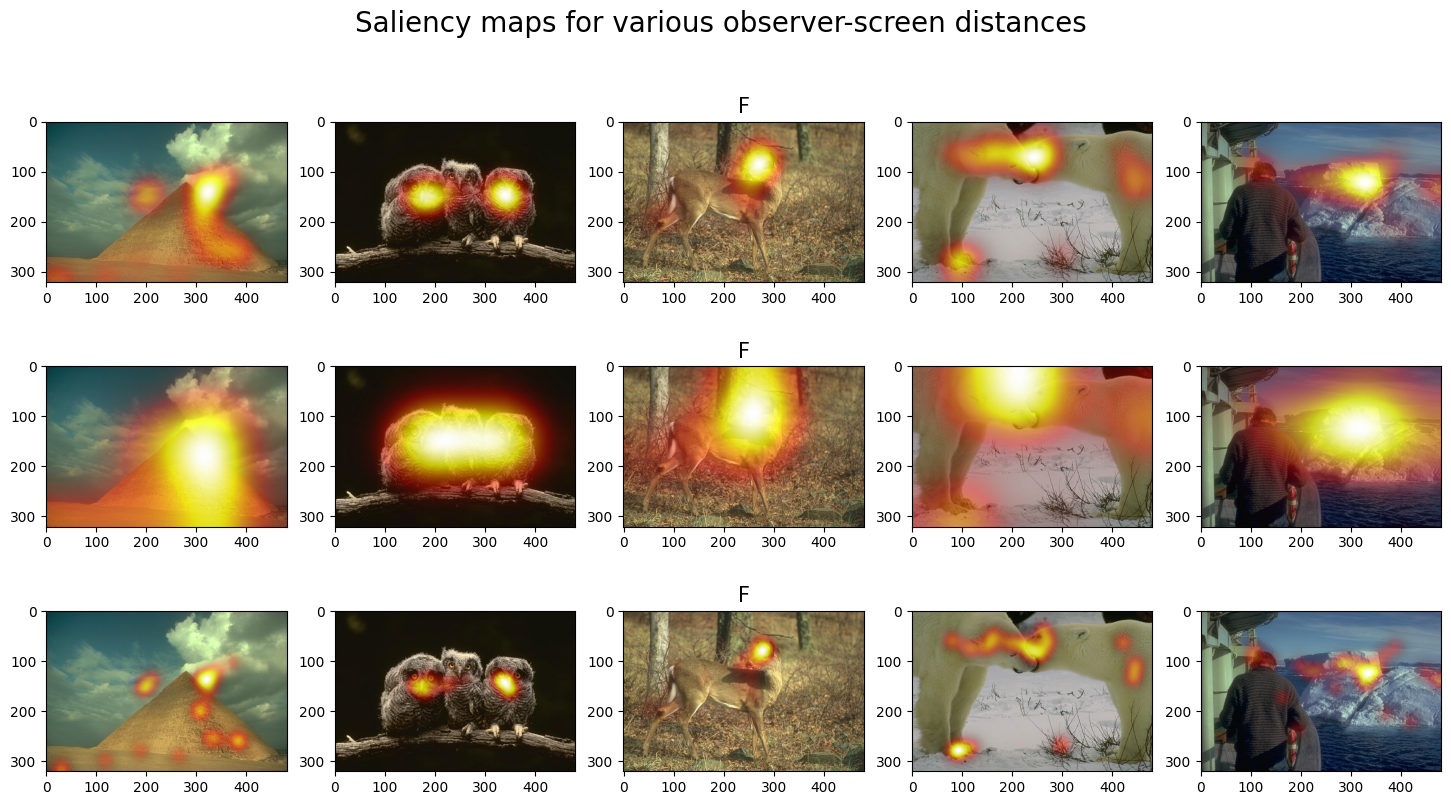

In [11]:
small_img_list = [2,7,8,14,27]
ncols = len(small_img_list)
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3 * nrows))

# Original
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[0, idx % ncols].imshow(img)
    axs[0, idx % ncols].imshow(salmap_rgba)
axs[0, 2].set_title(f'F', fontsize=15)

# Modified
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(1000, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[1, idx % ncols].imshow(img)
    axs[1, idx % ncols].imshow(salmap_rgba)
axs[1, 2].set_title(f'F', fontsize=15)

# Modified
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(200, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[2, idx % ncols].imshow(img)
    axs[2, idx % ncols].imshow(salmap_rgba)
axs[2, 2].set_title(f'F', fontsize=15)
plt.suptitle("Saliency maps for various observer-screen distances", fontsize=20)
plt.show()

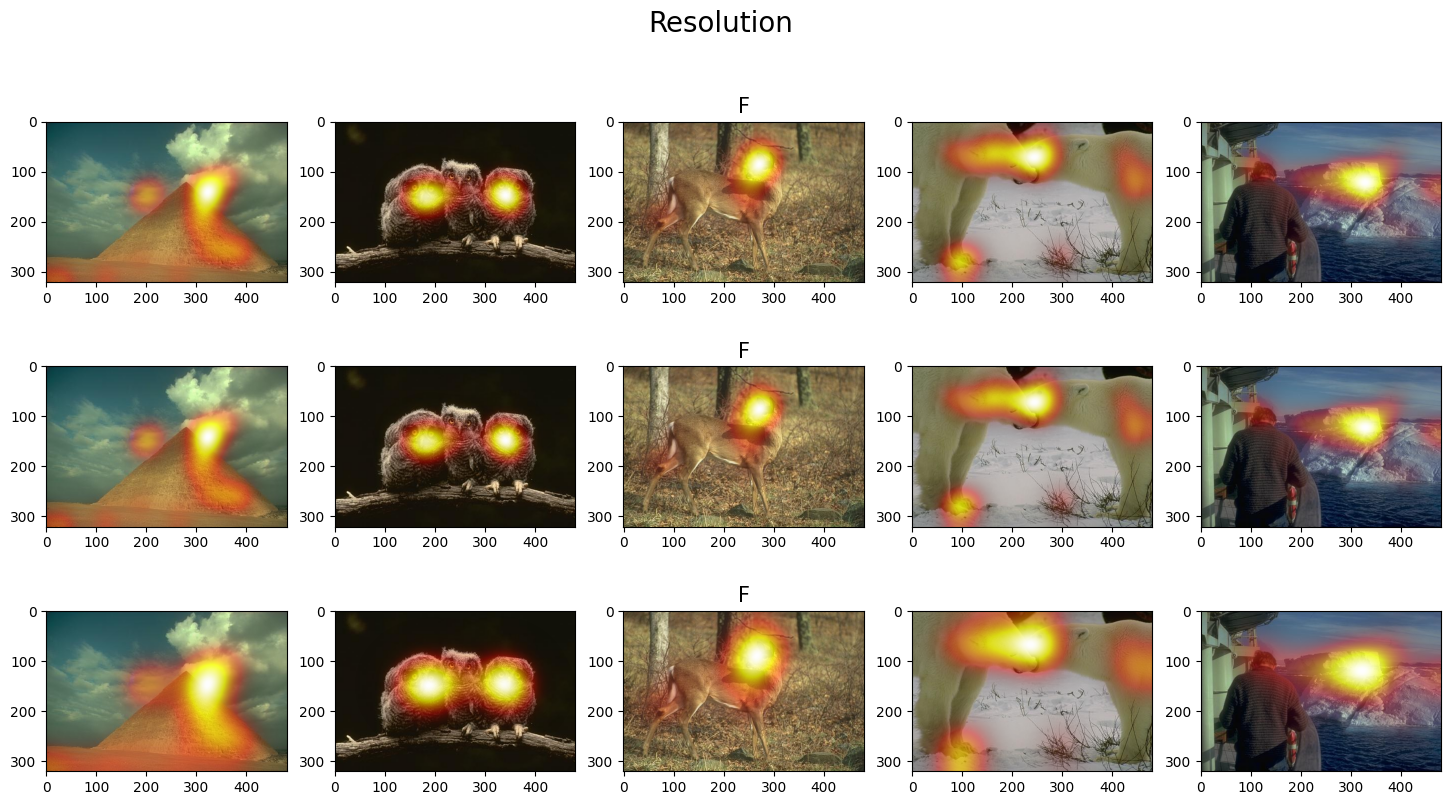

In [12]:
small_img_list = [2,7,8,14,27]
ncols = len(small_img_list)
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 3 * nrows))

# Original
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280, 1024, 338, 270)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[0, idx % ncols].imshow(img)
    axs[0, idx % ncols].imshow(salmap_rgba)
axs[0, 2].set_title(f'F', fontsize=15)

# Modified
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280/4, 1024/4, 338/4, 270/4)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[1, idx % ncols].imshow(img)
    axs[1, idx % ncols].imshow(salmap_rgba)
axs[1, 2].set_title(f'F', fontsize=15)

# Modified
for idx, img_num in enumerate(small_img_list):
    img_name = 'img.trn.' + str(img_num) + '.png'

    list_img1 = get_files_all_observers(PATH_DATA, img_name + '-obs_Obs1')
    fixmap = create_fixmap(list_img1, 481, 321, FACTOR_X, FACTOR_Y)
    img = mpimg.imread(os.path.join(PATH_DATA, "Images\\" + img_name))
    hppda, vppda = compute_ppda(415.8, 1280*4, 1024*4, 338*4, 270*4)
    salmap = salmap_from_fixmap(fixmap, vppda)

    # for a nice alpha canal
    norm = Normalize(vmin=salmap.min(), vmax=salmap.max())
    salmap_rgba = plt.cm.hot(norm(salmap))
    salmap_rgba[:,:,3] = norm(salmap)
    
    axs[2, idx % ncols].imshow(img)
    axs[2, idx % ncols].imshow(salmap_rgba)
axs[2, 2].set_title(f'F', fontsize=15)
plt.suptitle("Resolution", fontsize=20)
plt.show()